# NEURAL STYLE TRANSFER 

The code in this script is inspired from the algorithm created by Gatys et al. (2015) - # Deep Learning & Art: Neural Style Transfer

Welcome to the second assignment of this week. In this assignment, you will learn about Neural Style Transfer. This algorithm was created by Gatys et al. (2015) (https://arxiv.org/abs/1508.06576). 

Algorithm overview - 
the cost function containing style cost and content cost will be optimized to generate a new image.

### Installing Dependencies

In [1]:
import tensorflow as tf
from tensorflow.keras.applications.vgg19 import preprocess_input
from tensorflow.keras.models import Model
import matplotlib.pyplot as plt
import numpy as np

%matplotlib inline

print(tf.__version__)

2.13.0


## Helper Functions

In [2]:
# function to load image
def load_img(path_to_img, ps=0):
    
    max_dim = 400 # maximum alllowed width or height of input image
    
    img = tf.io.read_file(path_to_img) #read contents of image at 'path_to_img' in raw binary data 
    img = tf.image.decode_image(img, channels=3)  # encode binary data to tensor with 3 color channels
    img = tf.image.convert_image_dtype(img, tf.float32)  # image data converted to floating point with dtype tf.float32
    img = tf.image.resize(img, (500,500))
    img = img[tf.newaxis, :] 
        
    return img

In [3]:
# Gram matrix
def gram_matrix(tensor):

    temp = tensor
    temp = tf.squeeze(temp)
    fun = tf.reshape(temp, [temp.shape[2], temp.shape[0]*temp.shape[1]])
    result = tf.matmul(temp, temp, transpose_b=True)
    gram = tf.expand_dims(result, axis=0)
    
    return gram

### Neural style transfer

What is NST?
NST is a technique to merge two images C-'content' and S - 'supply' imaeges to create a new image G - 'Generated'.

In this script I have used VGG-19 pretrained model trained on ImageNet database. The model has learned to recognize various low level and high lelel features.

### NST algorithm has 3 steps :-

    1. Build content cost function J_C (c,g) 
    2. Build style cost function J_S (s,g)
    3. Calculate weighted total cost J(g) = alpha*J_C + beta*J_S

### Load Model

In [4]:
vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet')
vgg.trainable = False

For my code I will be working on the image of Taj Mahal as the content image and an abstract art image as style image.

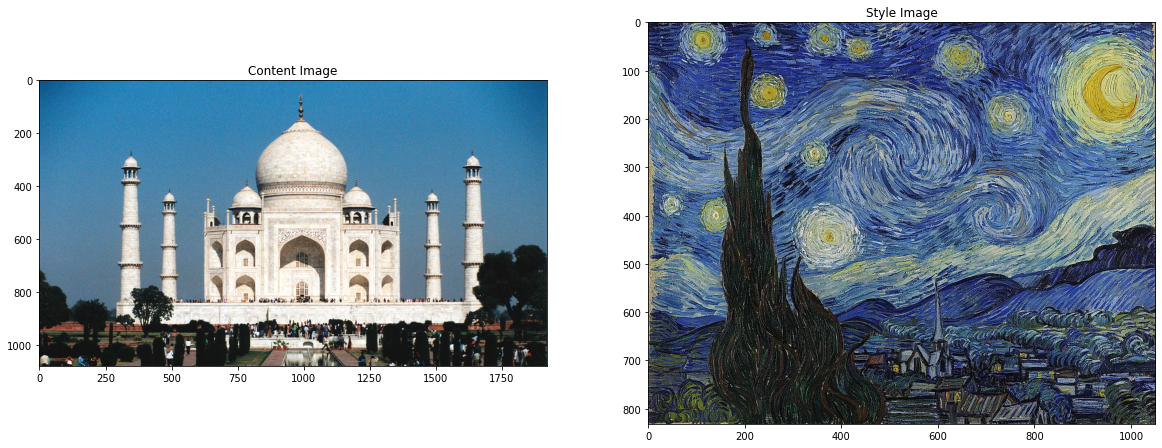

In [5]:
# Load the content and style images
content = plt.imread('images/tajmahal.jpg')
style = plt.imread('images/starry_night.png')

# Display the images
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))

# Content and style images side-by-side
ax1.imshow(content)
ax1.set_title('Content Image')
ax2.imshow(style)
ax2.set_title('Style Image')
plt.show()

In [6]:
content = load_img('images/tajmahal.jpg')
style = load_img('images/starry_night.png')

1. Content Cost

we want the generated cost to bw similar to the content image. For doing so the paper suggests to compare the hidden layer activations of the model for content and gernerated image an compare the loss and minimize it.

2. Style Cost

The style information of image is saved in the channels of the convolutional layers. we will find the correlation between different units of channels of different layers. For this we need to find a gram matrix.

The papers suggests to use following layers for calculating style and content cost.

In [7]:
# Content layer
content_layers = ['block4_conv2']

# Style layer
style_layers = ['block1_conv1',
                'block2_conv1',
                'block3_conv1',
                'block4_conv1',
                'block5_conv1']


num_content_layers = len(content_layers)
num_style_layers = len(style_layers)

In [8]:
# Custom weights for style and content updates
style_weight=100
content_weight=10

style_weights = {'block1_conv1': .5,
                 'block2_conv1': .8,
                 'block3_conv1': 1,
                 'block4_conv1': .5,
                 'block5_conv1': .5}

In [9]:
# function to get output layers of model VGG-19 model
def mini_model(layer_names, model):

    outputs = [model.get_layer(name).output for name in layer_names]

    model = Model([vgg.input], outputs)
    return model

### Main fucntion to process the code

In [10]:
class Custom_Style_Model(tf.keras.models.Model):
    
    def __init__(self, style_layers, content_layers):
        super(Custom_Style_Model, self).__init__()
        self.vgg =  mini_model(style_layers + content_layers, vgg)
        self.style_layers = style_layers
        self.content_layers = content_layers
        self.num_style_layers = len(style_layers)
        self.vgg.trainable = False

    def call(self, inputs):
        
        # Scale back the pixel values
        inputs = inputs*255.0
        # Preprocess them with respect to VGG19 stats
        preprocessed_input = preprocess_input(inputs)
        # Pass through the mini network
        outputs = self.vgg(preprocessed_input)
        # Segregate the style and content representations
        style_outputs, content_outputs = (outputs[:self.num_style_layers],
                                          outputs[self.num_style_layers:])

        # Calculate the gram matrix for each layer
        style_outputs = [gram_matrix(style_output)
                         for style_output in style_outputs]

        # Assign the content representation and gram matrix in
        # a layer by layer fashion in dicts
        content_dict = {content_name:value
                        for content_name, value
                        in zip(self.content_layers, content_outputs)}

        style_dict = {style_name:value
                      for style_name, value
                      in zip(self.style_layers, style_outputs)}

        return {'content':content_dict, 'style':style_dict}

In [11]:
# The content and style images are loaded in content and style variables respectively
extractor = Custom_Style_Model(style_layers, content_layers)
style_targets = extractor(style)['style']
content_targets = extractor(content)['content']

In [12]:
# The final loss function to optimize

def total_loss(outputs):
    
    style_outputs = outputs['style']
    content_outputs = outputs['content']
    
    #style loss calculation using gram matrix
    # Here custom weights for the different layers for caculating style loss is used
    style_loss = tf.add_n([style_weights[name]*tf.reduce_mean((style_outputs[name]-style_targets[name])**2)
                           for name in style_outputs.keys()])
    # Normalize
    style_loss *= style_weight / num_style_layers

    content_loss = tf.add_n([tf.reduce_mean((content_outputs[name]-content_targets[name])**2)
                             for name in content_outputs.keys()])
    # Normalize
    content_loss *= content_weight / num_content_layers
    
    loss = style_loss + content_loss
    
    return loss

In [13]:
# Function to finally generate the image 

In [14]:
# Using the Adam Optimizer
opt = tf.optimizers.Adam(learning_rate=.01)

In [15]:
@tf.function()
def train_step(image):
    with tf.GradientTape() as tape:
        # Extract the features
        outputs = extractor(image)
        # Calculate the loss
        loss = total_loss(outputs)
        # Determine the gradients of the loss function w.r.t the image pixels
        grad = tape.gradient(loss, image)
        # Update the pixels
        opt.apply_gradients([(grad, image)])
        # Clip the pixel values that fall outside the range of [0,1]
        image.assign(tf.clip_by_value(image, clip_value_min=0.0, clip_value_max=1.0))

In [16]:
# Finally Generate the new Image

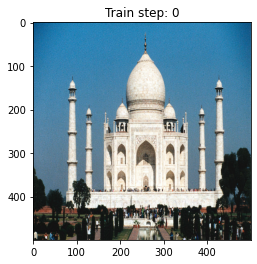

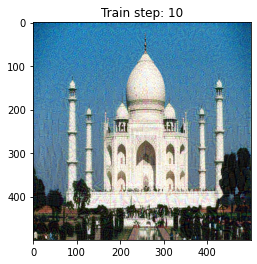

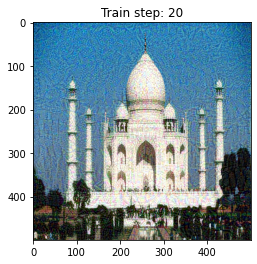

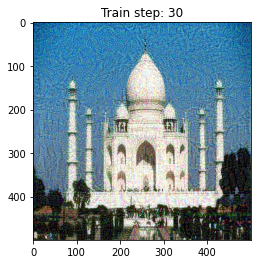

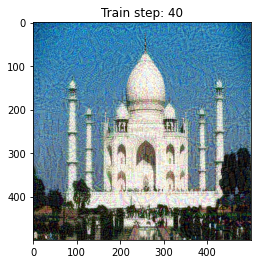

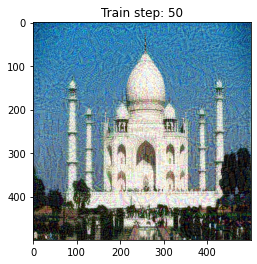

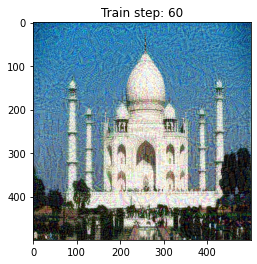

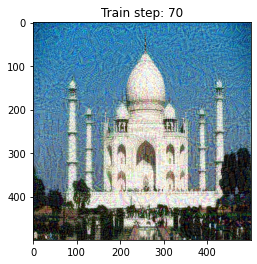

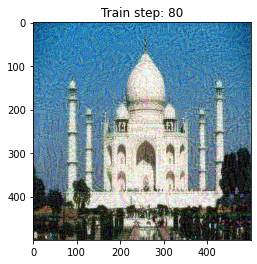

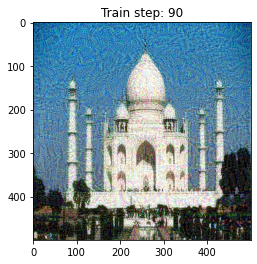

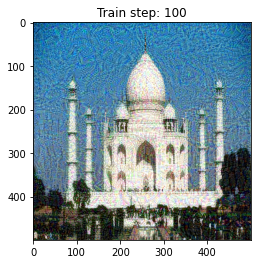

In [23]:
target_image = tf.Variable(content)
epochs = 101

step = 0
for n in range(epochs):
    
    train_step(target_image)
    
    if(n%10==0):
        
        plt.imshow(np.squeeze(target_image.read_value(), 0))
        plt.title("Train step: {}".format(n))
        
        # Save the image locally
        save_path = 'generated_images/gen_img_{}.png'.format(n)
        plt.savefig(save_path)
        plt.show()

### Potential Improvements

1. One can optimize the weightage of respective convolutional block layers style loss calculation. The earlier layers capture small level features/styles and later layers capture high level features.

2. one can also play with the respective weightage of the style cost and content cost to look at the beauty aspect of the art.

### Limitations:

a. The algorithm involves optimization problem which is computational expesive.

b. I have used UGG-19 model which requires high memory for optimization

c. This algorithm takes too much time to process 1 image thus can't be used for real time apllication.

d. This algorithm can learn parameters for trasnfering single content image for single style image only. 

e. It is also difficult to do parameter tuning.

### Improved algorithm:

I came across much more better algorithm for style transfer given in the paper :
    https://arxiv.org/abs/1703.06868

the algorithm proposed in this paper is capable of arbitrary style transfer in real-time. They have employed the concept of adaotive instance normalization (ADAIN) layer that uses the mean and variance of the content features with those of style features.
The model is capable of  giving content-style trade-off, color & spatial controls, all using a single feed-forward neural network.